# <span style="color: tomato;">Tarea Grupal Tech: Entrenamiento de ML y archivos .pkl </span>

## <span style="color: pink;">Grupo: </span>
Desirée Vera, Felipe Gómez, Harmynn Garrido y Diego Granados


### <span style="color: darkorange;">Parte A: Descripción de Datos </span>

Se busca predecir si un  cliente se no pagará sus obligaciones a través de un modelo de clasificación.

El problema es el no pago de las deudas (default) de los clientes, por lo que se busca determinar si un cliente determinado caerá en default o no, esto tiene un impacto económico en las instituciones crediticias.  La variable objetivo es binaria, 1 si el cliente incurre en default y 0 cliente cumple con el pago.

En el archivo “Tabla Trabajo Grupal N°2”, se encuentran dos tablas (Modelamiento y Predicción) con los siguientes 
campos para el modelamiento binario:

• Edad: Campo cuantitativo que detalla la edad del cliente.

• Nivel Educacional: Campo categórico que detalla el nivel educacional del cliente.

• Años Trabajando: Campo cuantitativo con el detalle de los años trabajando del cliente.

• Ingresos: Campo cuantitativo que detalla el monto encriptado del ingreso del cliente.

• Deuda Comercial: Campo cuantitativo que detalla la deuda comercial del cliente.

• Deuda Crédito: Campo cuantitativo que detalla la deuda consumo en crédito del cliente.

• Otras Deudas: Campo cuantitativo que detalla el monto deudas, no comerciales ni consumo del cliente.

• Ratio Ingresos Deudas: Campo cuantitativo que detalla la proporción de ingresos sobre deudas totales del cliente.

• Default: Campo cuantitativa binaria, que detalla el incumplimiento del cliente en el pago (target).

In [1]:
# Importar librerías 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
from scipy.stats import zscore
from scipy import stats
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.covariance import MinCovDet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, Ridge # Importar el modelo Ridge Cross Validation
from sklearn.linear_model import ElasticNetCV, ElasticNet # Importar ElasticNet
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [2]:

# Cargar archivo Excel de "MODELAMIENTO_MONTO_FRAUDE"
archivo = "Tabla Trabajo Grupal N°2.xlsx"
df = pd.read_excel(archivo, sheet_name='Desarrollo')

### <span style="color: darkorange;">Parte B: Inspección y Limpieza de Datos </span>

In [3]:
df.shape
print(f'La base de datos cuenta con {df.shape[0]} registros o filas y {df.shape[1]} variables o columnas')

La base de datos cuenta con 12356 registros o filas y 10 variables o columnas


In [4]:
# Limpia los espacios en blanco en los nombres de las columnas del DataFrame
df.columns = df.columns.str.strip()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12356 entries, 0 to 12355
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id_Cliente             12356 non-null  int64  
 1   Edad                   12356 non-null  int64  
 2   Nivel_Educacional      12356 non-null  object 
 3   Años_Trabajando        12356 non-null  int64  
 4   Ingresos               12356 non-null  int64  
 5   Deuda_Comercial        12356 non-null  float64
 6   Deuda_Credito          12356 non-null  float64
 7   Otras_Deudas           12356 non-null  float64
 8   Ratio_Ingresos_Deudas  12356 non-null  float64
 9   Default                12356 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 965.4+ KB


Todas las variables tienen la misma cantidad de datos no nulos, que coincide con el número de registros, por lo que se presume que no hay datos faltantes.

Sólo hay una variable objeto `Nivel_Educacional` el resto son númericas, 5 variables del tipo int64 (números enteros) y 4 variables del tipo float64 (continuas)

La variable `Id_Cliente` es el indicador único de los registros.

In [6]:
# Verificar existencia filas duplicadas
duplicados = df.duplicated()
print(f"Filas duplicadas encontradas: {duplicados.sum()}")


# Si hay duplicados, los eliminamos para evitar sesgos en el análisis
df = df.drop_duplicates()
print(f"Nueva forma del dataset después de eliminar duplicados: {df.shape}")
print(f'La nueva base de datos cuenta con {df.shape[0]} registros o filas y {df.shape[1]} variables o columnas')

Filas duplicadas encontradas: 0
Nueva forma del dataset después de eliminar duplicados: (12356, 10)
La nueva base de datos cuenta con 12356 registros o filas y 10 variables o columnas


In [7]:
# Se elimina la variable ID_Cliente

df.drop(columns= ['Id_Cliente'], inplace=True)

In [8]:
# Buscar datos faltantes por columna
df.isnull().sum()

Edad                     0
Nivel_Educacional        0
Años_Trabajando          0
Ingresos                 0
Deuda_Comercial          0
Deuda_Credito            0
Otras_Deudas             0
Ratio_Ingresos_Deudas    0
Default                  0
dtype: int64

Se confirma la no existencia de datos faltantes, por lo que no hay que hacer ningún tipo de imputación por ese motivo.

### <span style="color: darkorange;">Parte C: Análisis Exploratorio de Datos </span>

In [9]:
# Primeras 5 filas
df.head()

,Edad,Nivel_Educacional,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Default
0,34,SupInc,11,68,11.9,3.37,4.73,0.29,1
1,43,Med,3,53,9.8,1.51,3.69,0.28,0
2,36,SupInc,7,118,11.2,8.48,4.73,0.21,0
3,46,Bas,11,61,10.4,3.44,2.90,0.27,1
4,29,Med,0,21,12.4,0.38,2.22,0.71,0


In [10]:
df.describe()

,Edad,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Default
count,12356.000000,12356.000000,12356.000000,12356.000000,12356.000000,12356.000000,12356.000000,12356.000000
mean,34.165426,6.945856,59.747734,9.945792,1.959126,3.871186,0.365641,0.632810
std,13.136804,8.994143,67.204209,6.733845,3.024585,5.438903,0.295756,0.482058
min,18.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,27.000000,4.800000,0.420000,1.090000,0.150000,0.000000
50%,31.000000,4.000000,40.000000,8.500000,1.000000,2.210000,0.290000,1.000000
75%,42.000000,10.000000,64.000000,13.600000,2.210000,4.590000,0.500000,1.000000
max,79.000000,63.000000,1079.000000,40.700000,35.970000,63.470000,2.150000,1.000000


Al examinar el dataframe se aprecia:

(i) existencia de datos outliers en `Años_Trabajando`, `Ingresos`, `Deuda_Comercial`,`Deuda_Credito`, `Otras_Deudas` y `Ratio_Ingresos_Deudas` dado que el promedio y la mediana son muy distintos, la desviación estándar es mayor que el promedio y que el valor máximo es más del doble que el tercer cuartil (Q3) en casi todas.  Son variables con sesgo a la derecha y puede que no sean normales.

(ii) la variable `Default` es binaria y contiene 63,28% de defaults (1).

In [11]:
df.describe(include='object')

,Nivel_Educacional
count,12356
unique,5
top,Med
freq,4320


respecto a la variable `Nivel_Educacional` tiene cinco categorias, entre la cuales Med es la más común con casi un tercio de las observaciones.

In [12]:
df['Nivel_Educacional'].value_counts()

Nivel_Educacional
Med       4320
SupInc    2766
SupCom    2580
Bas       2005
Posg       685
Name: count, dtype: int64

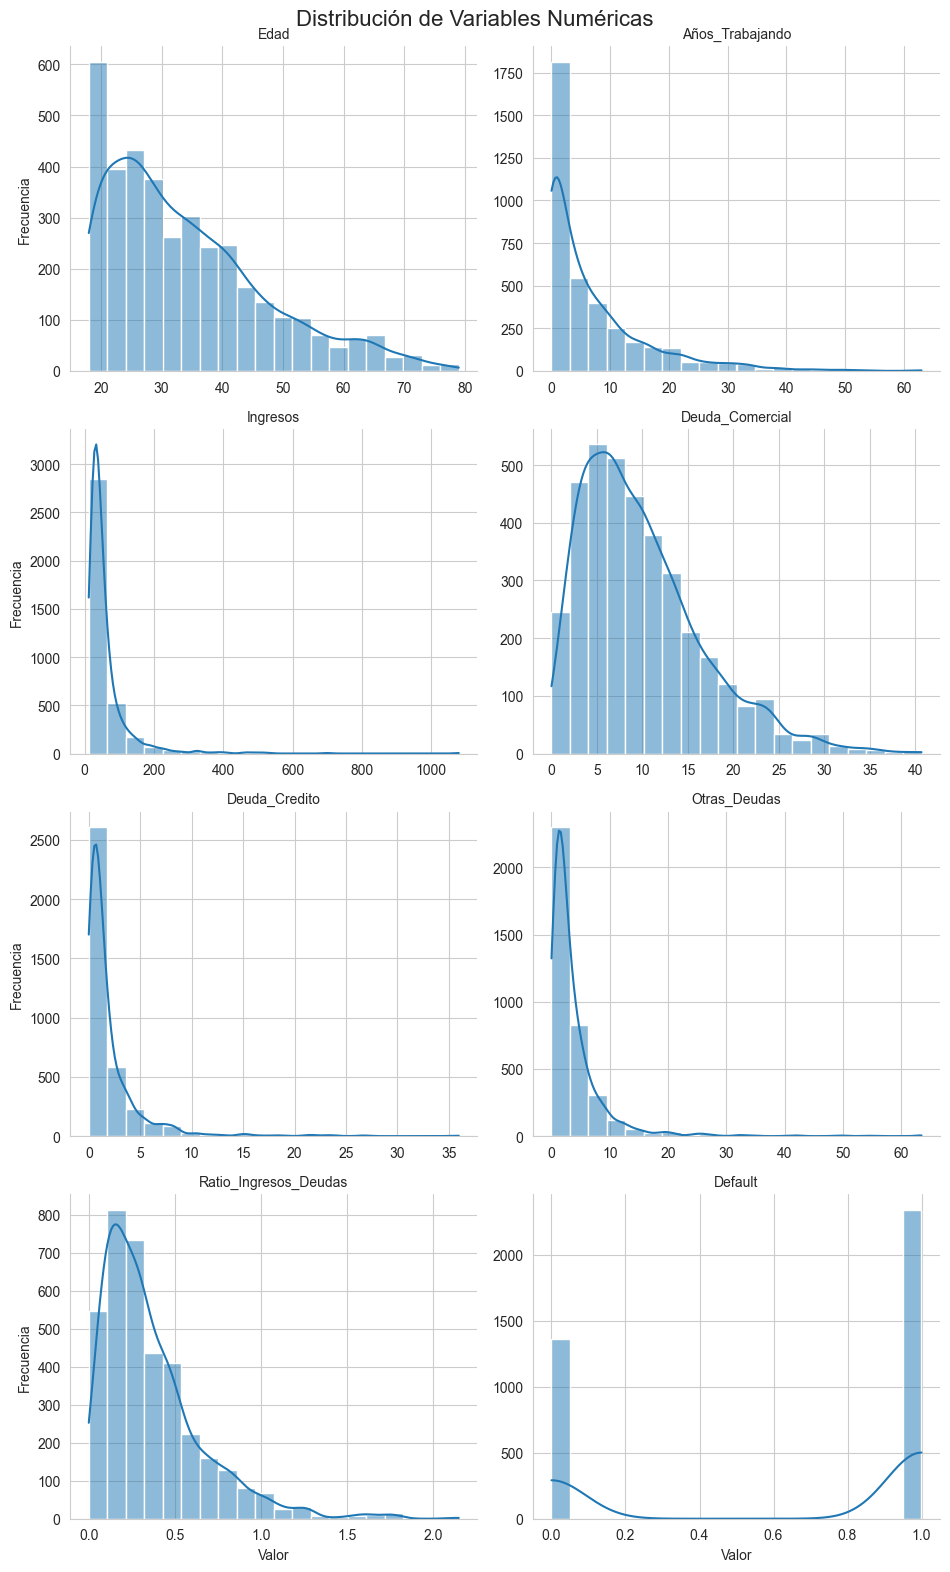

In [44]:
# Seleccionar las columnas numéricas para el histograma
variables_numericas = ['Edad', 'Años_Trabajando', 'Ingresos', 'Deuda_Comercial', 'Deuda_Credito',  'Otras_Deudas', 'Ratio_Ingresos_Deudas', 'Default']

# Crear un DataFrame de "largo" para usar con FacetGrid
# Esto es necesario para que cada variable se convierta en una fila de datos
df_histograma = df[variables_numericas].melt(var_name='variable', value_name='valor')

# Crear el FacetGrid y dibujar los histogramas
g = sns.FacetGrid(
    data=df_histograma,
    col='variable',
    col_wrap=2, # Envuelve las columnas en 2 filas
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.2
)

# Mapear el histograma a cada subgráfico
g.map(sns.histplot, 'valor', bins=20, kde=True)

# Ajustar títulos y etiquetas
g.set_axis_labels("Valor", "Frecuencia")
g.set_titles(col_template="{col_name}")

# Agregar un título principal al gráfico
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribución de Variables Numéricas', fontsize=16)

plt.tight_layout()
plt.show()

Se aprecia que:

los clientes tienen mayoritariamente entre 20 y 30 años.

los clientes tienen mayoritariamente menos de 1 año de experiencia.

el ingreso se concentra en las 40 unidades monetarias.

la deuda comercial se concentra en 8.5 unidades. 

la deuda de consumo se concentra bajo las 1.0 unidades.

las otras deudas se concentran bajo las 2.2 unidades.

el ratio de ingresos a deuda se concentra bajo los 0,3.

en la variable objetivo, puede considerarse hacer un balanceo.

no se hará nada con los outliers, presentes en todas las variables, dado que pueden aportar información importante al modelo, puede generar entrenamiento importante al modelo en situaciones extremas prse a que puede generar más errores dada varianza de los datos. 

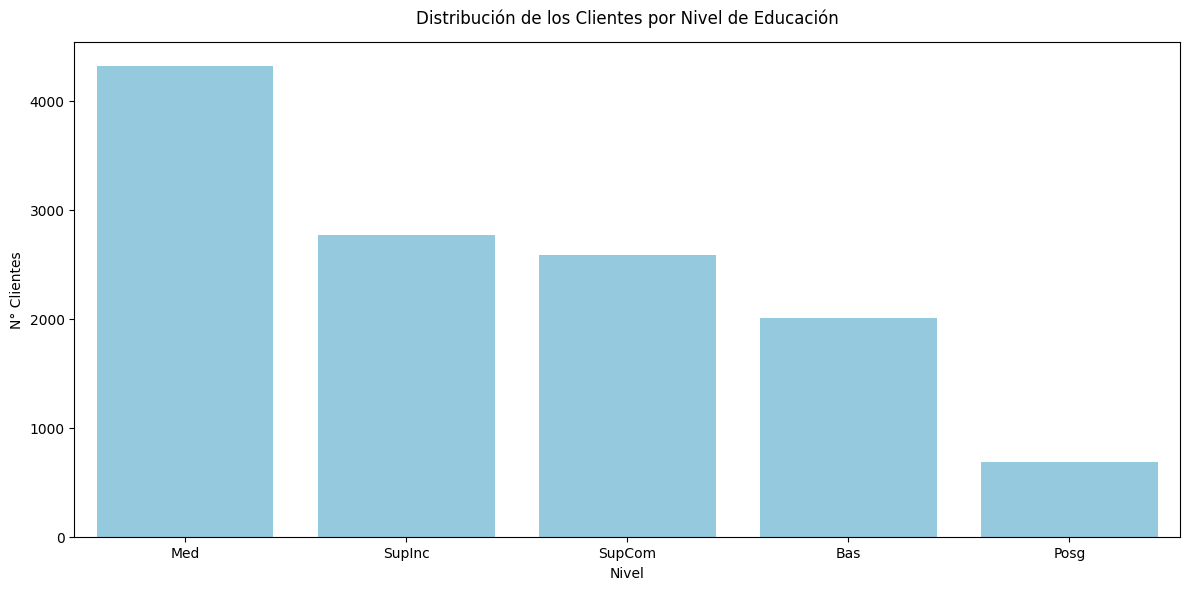

In [14]:
# --- GRÁFICO: Educación ---

conteo=df['Nivel_Educacional'].value_counts().reset_index()
conteo.columns=['Nivel_Educacional', 'Cantidad']
plt.figure(figsize=(12,6))
sns.barplot(
    data=conteo,
    x='Nivel_Educacional',
    y='Cantidad',
    color='skyblue'
)

# Añadir títulos y etiquetas
plt.title('Distribución de los Clientes por Nivel de Educación', y=1.02)
plt.xlabel("Nivel")
plt.ylabel("N° Clientes")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### <span style="color: darkorange;">Parte D: Modelamiento de Datos </span>

#### <span style="color: red;">1. Selección de las Muestras: </span>


In [15]:
# DIVISIÓN DE LOS DATOS EN TRAIN Y TEST

df_train, df_test = train_test_split(df, test_size=0.3, random_state=21)

# Imprimir las formas de los nuevos DataFrames para verificar que la división se hizo correctamente
print(f"Forma del conjunto de entrenamiento (df_train): {df_train.shape}")
print(f"Forma del conjunto de prueba (df_test): {df_test.shape}")

Forma del conjunto de entrenamiento (df_train): (8649, 9)
Forma del conjunto de prueba (df_test): (3707, 9)


Se procedió a:

(i) separar el dataframe aleatoreamente con una semilla predefinida (random_state=21) para la replicabilidad): 

 a-  el 70% de los registros **df_train** con 8649 filas y 9 columnas

 b-  el 30% de los registros **df_test** con 3707 filas y 9 columnas


#### <span style="color: red;">2. Análisis Descriptivo: </span>



In [16]:
# Estadisticas descriptivas

df_train.describe(include="all")


,Edad,Nivel_Educacional,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Default
count,8649.000000,8649,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000
unique,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Med,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2975,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34.147416,NaN,6.950168,59.988322,9.971349,1.968485,3.913915,0.366373,0.633021
std,13.148581,NaN,9.022235,66.795487,6.757645,3.047871,5.551821,0.296148,0.482009
min,18.000000,NaN,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,NaN,0.000000,27.000000,4.700000,0.420000,1.100000,0.150000,0.000000
50%,31.000000,NaN,4.000000,40.000000,8.500000,1.010000,2.240000,0.290000,1.000000
75%,42.000000,NaN,10.000000,65.000000,13.600000,2.260000,4.640000,0.500000,1.000000


In [17]:
df_test.describe(include="all")

,Edad,Nivel_Educacional,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas,Default
count,3707.000000,3707,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000
unique,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Med,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34.207445,NaN,6.935797,59.186404,9.886161,1.937289,3.771492,0.363933,0.632317
std,13.110962,NaN,8.929458,68.154071,6.678513,2.969837,5.165213,0.294873,0.482239
min,18.000000,NaN,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,NaN,0.000000,27.000000,4.800000,0.440000,1.080000,0.150000,0.000000
50%,31.000000,NaN,4.000000,39.000000,8.500000,0.980000,2.170000,0.290000,1.000000
75%,41.000000,NaN,10.000000,62.000000,13.300000,2.160000,4.565000,0.490000,1.000000


In [19]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8649 entries, 9404 to 5327
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Edad                   8649 non-null   int64  
 1   Nivel_Educacional      8649 non-null   object 
 2   Años_Trabajando        8649 non-null   int64  
 3   Ingresos               8649 non-null   int64  
 4   Deuda_Comercial        8649 non-null   float64
 5   Deuda_Credito          8649 non-null   float64
 6   Otras_Deudas           8649 non-null   float64
 7   Ratio_Ingresos_Deudas  8649 non-null   float64
 8   Default                8649 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 675.7+ KB


In [21]:
df_train.groupby('Nivel_Educacional', observed=False)['Default'].describe()

,count,mean,std,min,25%,50%,75%,max
Nivel_Educacional,,,,,,,,
Bas,1410.0,0.734043,0.441998,0.0,0.0,1.0,1.0,1.0
Med,2975.0,0.618824,0.485757,0.0,0.0,1.0,1.0,1.0
Posg,500.0,0.694000,0.461291,0.0,0.0,1.0,1.0,1.0
SupCom,1809.0,0.549475,0.497684,0.0,0.0,1.0,1.0,1.0
SupInc,1955.0,0.643478,0.479094,0.0,0.0,1.0,1.0,1.0


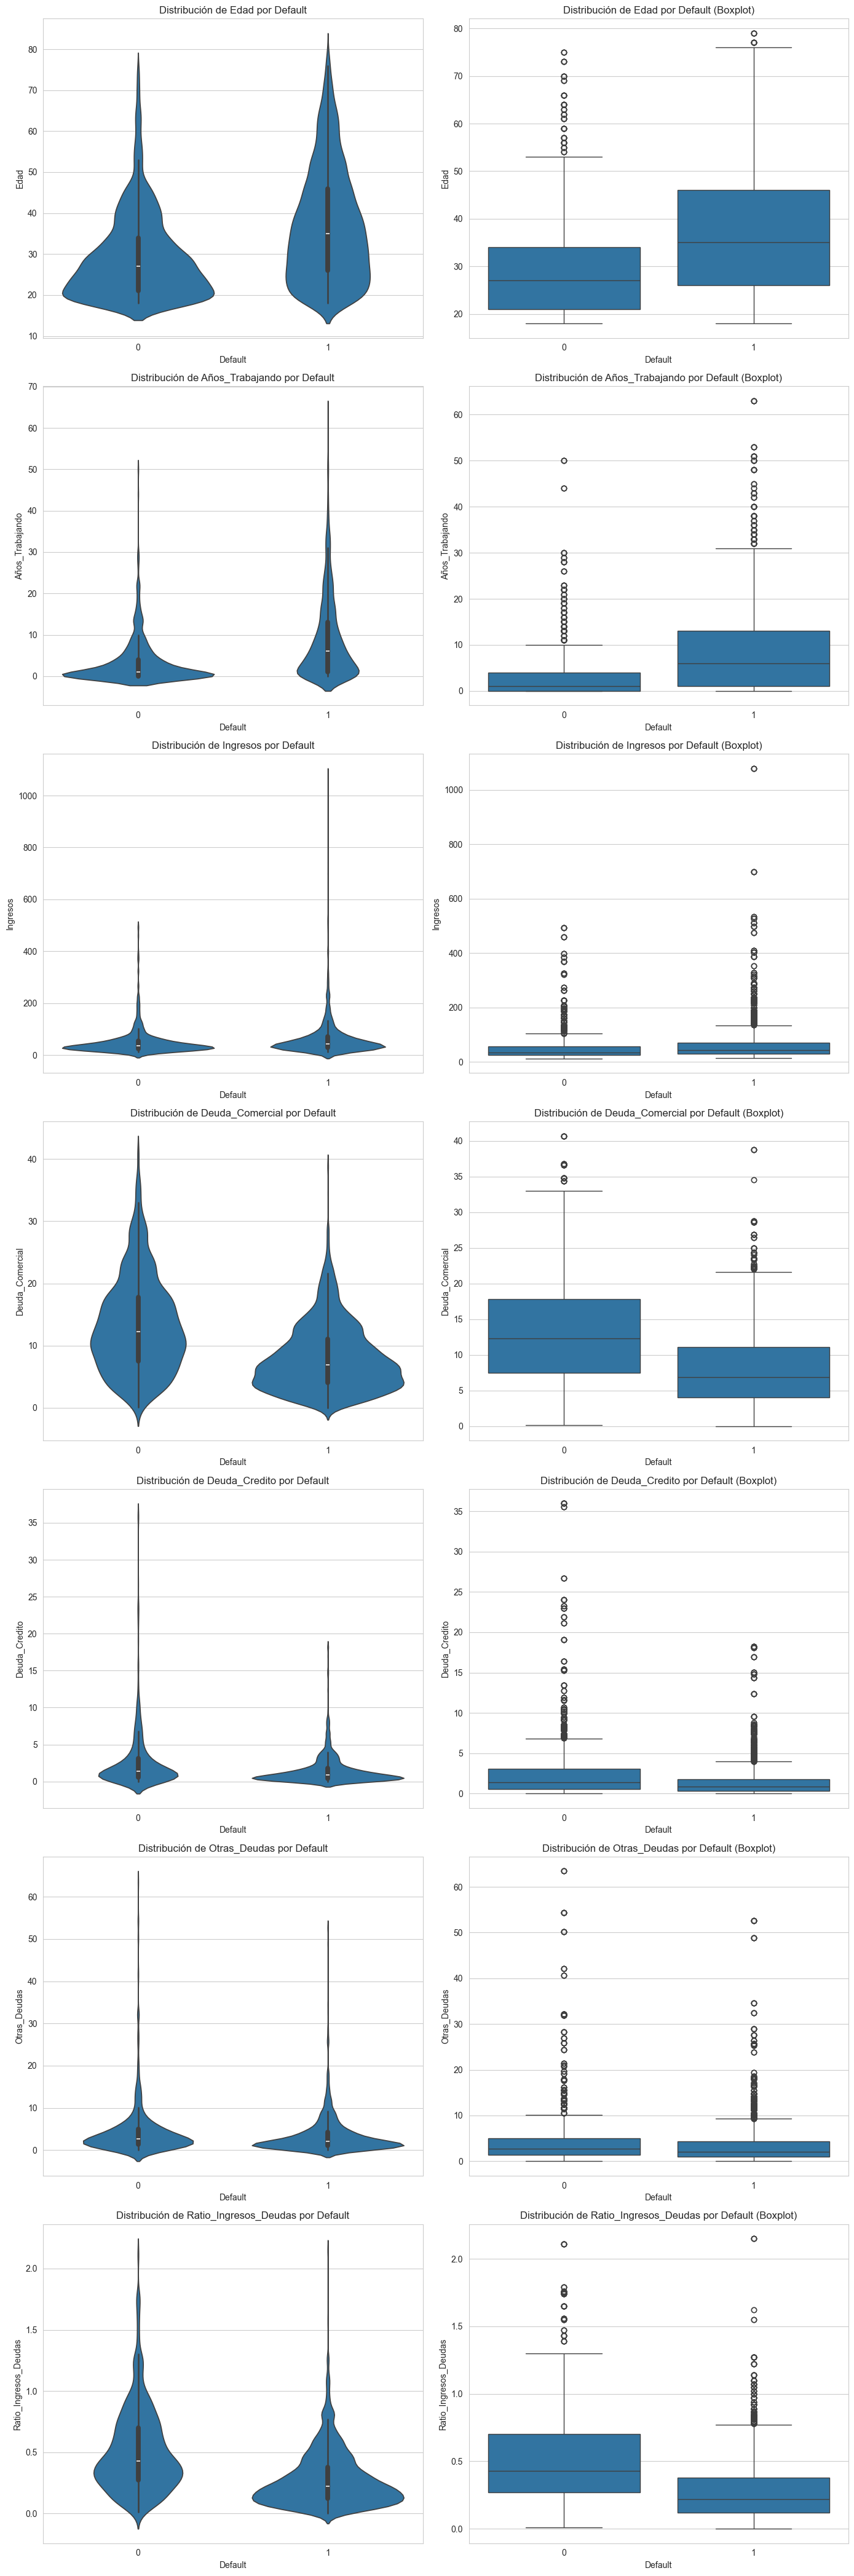

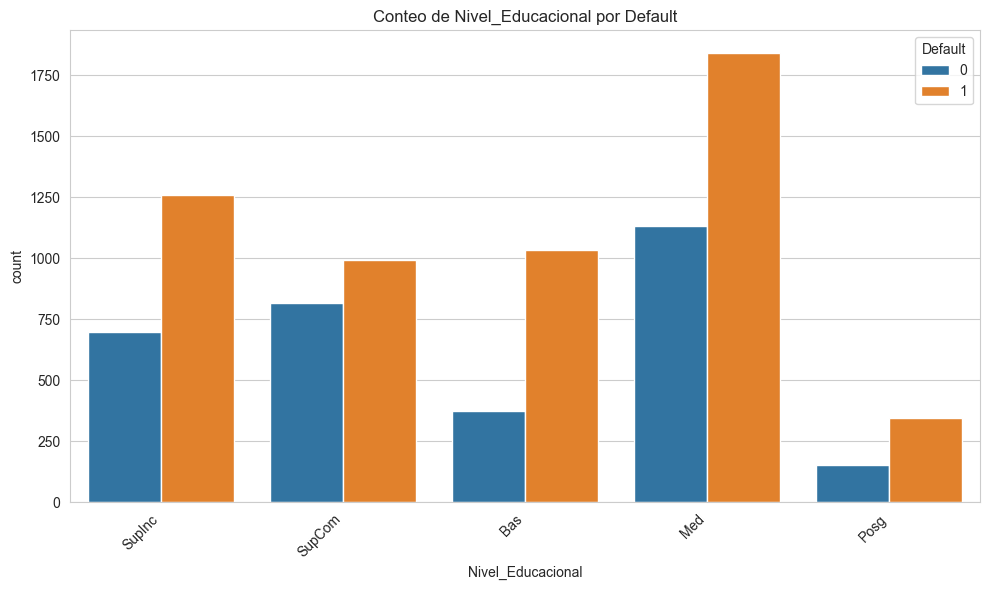

In [22]:
# Gráficos de las variables vs Default

# Define las variables
variables_numericas = ['Edad', 'Años_Trabajando', 'Ingresos', 'Deuda_Comercial', 'Deuda_Credito', 'Otras_Deudas', 'Ratio_Ingresos_Deudas']
variables_categoricas = ['Nivel_Educacional']
variable_objetivo = 'Default'

# Configuración de los gráficos
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=2, figsize=(14, 6 * len(variables_numericas)))

# Gráficos para variables numéricas
for i, col in enumerate(variables_numericas):
    # Gráfico de violín
    sns.violinplot(x=variable_objetivo, y=col, data=df_train, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución de {col} por Default')
    
    # Gráfico de caja (boxplot)
    sns.boxplot(x=variable_objetivo, y=col, data=df_train, ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribución de {col} por Default (Boxplot)')

plt.tight_layout()
plt.show()

# Gráficos para variables categóricas
for col in variables_categoricas:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue=variable_objetivo, data=df_train)
    plt.title(f'Conteo de {col} por Default')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

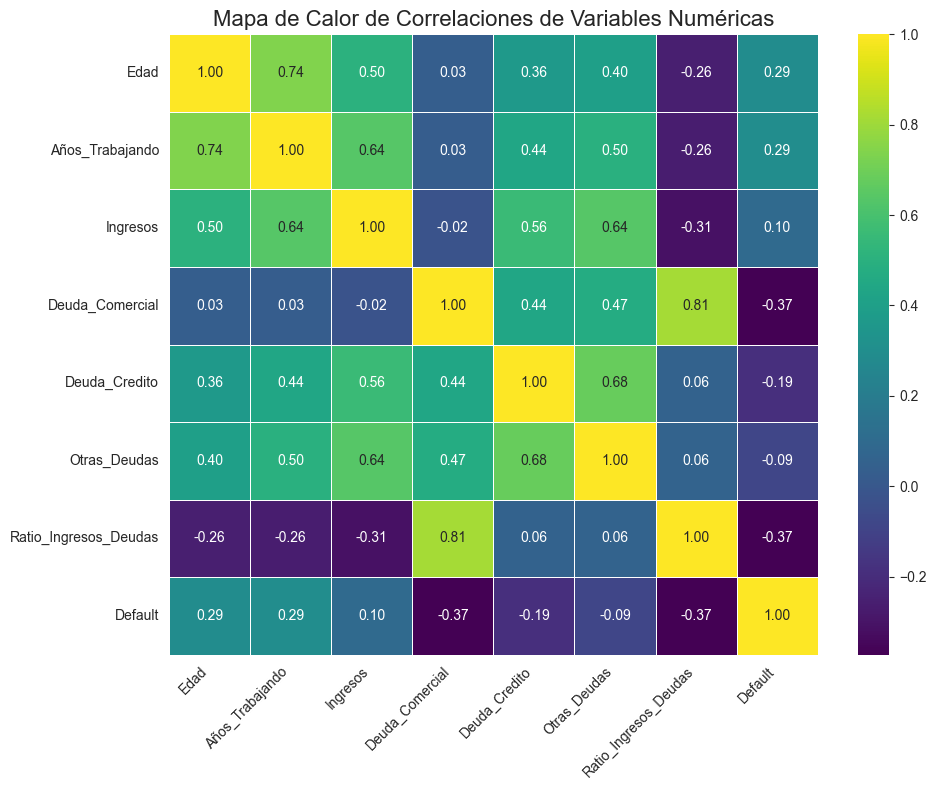

In [25]:
# Seleccionar solo las columnas numéricas relevantes para la correlación
columnas_numericas = ['Edad', 'Años_Trabajando', 'Ingresos', 'Deuda_Comercial', 'Deuda_Credito', 'Otras_Deudas', 'Ratio_Ingresos_Deudas', 'Default']
df_corr = df_train[columnas_numericas]

# Calcular la matriz de correlación de Pearson
correlation_matrix = df_corr.corr()

# --- Crear el mapa de calor ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,         # Muestra los valores de correlación en el mapa
    cmap='viridis',     # Elige un esquema de color (puedes probar otros como 'coolwarm', 'YlGnBu')
    fmt=".2f",          # Formato de los valores a dos decimales
    linewidths=.5       # Añade líneas entre las celdas
)

# Ajustar título
plt.title('Mapa de Calor de Correlaciones de Variables Numéricas', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Las correlaciones entre las variable son las siguientes:

`Edad` está correlacionada directa con `Años_trabajando` e `Ingresos`

`Años_Trabajando` además se correlaciona directamente con `Otras_Deudas`

`Ingresos` además se correlaciona directamente con `Deuda_Credito` y `Otras_Deudas`

`Deuda_Comercial` se correlaciona directamente con `Ratio_Ingresos_Deudas`

`Deuda_Credito` además se correlacioan directamente con `Otras_Deudas` 

`Default` solo tiene correlaciones débiles con el resto de las variables numéricas


#### <span style="color: red;">3. División de Tablas entrenamiento y testeo: </span>

In [27]:
# DIVISIÓN DE DATOS 

# Create a list with the names of the feature columns
feature_columns = ['Edad', 'Años_Trabajando', 'Ingresos', 'Deuda_Comercial', 'Deuda_Credito', 
                   'Otras_Deudas', 'Ratio_Ingresos_Deudas', 'Nivel_Educacional']

# Correctly select the feature columns using the list
x_train = df_train[feature_columns]
y_train = df_train['Default']
x_test = df_test[feature_columns]
y_test = df_test['Default']


#### <span style="color: red;">4. Creación y Transformación de Variables: </span>

In [28]:
# TRANSFORMANDO CON TARGET ENCODER 'Nivel_Educacional'

from category_encoders import TargetEncoder


# 1. Separar X y y para los conjuntos de entrenamiento y prueba
X_train = df_train.drop('Default', axis=1)
y_train = df_train['Default']

X_test = df_test.drop('Default', axis=1)
y_test = df_test['Default']

# 2. Inicializar el codificador
# Le indicamos la columna que queremos codificar
encoder = TargetEncoder(cols=['Nivel_Educacional'])

# 3. Ajustar (fit) el codificador ÚNICAMENTE en el conjunto de ENTRENAMIENTO
# Esto es vital para evitar la fuga de datos
encoder.fit(X_train, y_train)

# 4. Transformar los datos de entrenamiento y prueba
# Se usa el mapeo aprendido en el paso anterior para ambos sets
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Opcional: Mostrar los cambios en la variable codificada
print("Variable 'Nivel_Educacional' en X_train original:")
print(X_train['Nivel_Educacional'].head())
print("\nVariable codificada en X_train_encoded:")
print(X_train_encoded['Nivel_Educacional'].head())

print("\nVariable 'Nivel_Educacional' en X_test original:")
print(X_test['Nivel_Educacional'].head())
print("\nVariable codificada en X_test_encoded:")
print(X_test_encoded['Nivel_Educacional'].head())

Variable 'Nivel_Educacional' en X_train original:
9404     SupInc
1551     SupCom
12024       Bas
2594        Bas
5504        Med
Name: Nivel_Educacional, dtype: object

Variable codificada en X_train_encoded:
9404     0.643478
1551     0.549475
12024    0.734043
2594     0.734043
5504     0.618824
Name: Nivel_Educacional, dtype: float64

Variable 'Nivel_Educacional' en X_test original:
6467       Med
6628    SupInc
2104    SupCom
4638    SupInc
5647       Bas
Name: Nivel_Educacional, dtype: object

Variable codificada en X_test_encoded:
6467    0.618824
6628    0.643478
2104    0.549475
4638    0.643478
5647    0.734043
Name: Nivel_Educacional, dtype: float64


In [29]:
X_train_encoded.describe()


,Edad,Nivel_Educacional,Años_Trabajando,Ingresos,Deuda_Comercial,Deuda_Credito,Otras_Deudas,Ratio_Ingresos_Deudas
count,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000,8649.000000
mean,34.147416,0.633021,6.950168,59.988322,9.971349,1.968485,3.913915,0.366373
std,13.148581,0.058592,9.022235,66.795487,6.757645,3.047871,5.551821,0.296148
min,18.000000,0.549475,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.618824,0.000000,27.000000,4.700000,0.420000,1.100000,0.150000
50%,31.000000,0.618824,4.000000,40.000000,8.500000,1.010000,2.240000,0.290000
75%,42.000000,0.643478,10.000000,65.000000,13.600000,2.260000,4.640000,0.500000
max,79.000000,0.734043,63.000000,1079.000000,40.700000,35.970000,63.470000,2.150000


Dado que existe una relación entre `Nivel_Educacional` y `Default` se decidió codificar con *Target Encoding* cada uno de los niveles educacionales.

A partir de ahora se debe usar **X_train_encoded** y **X_test_encoded**

##### <span style="color: violet;">a. Modelo básico: </span>


📊 Resultados - TRAIN
AUC: 0.8450 | KS: 0.5121 | Threshold óptimo: 0.5126
Accuracy: 0.7735 | Precision: 0.7976 | Recall: 0.8606 | F1: 0.8279
Matriz de Confusión:
[[1978 1196]
 [ 763 4712]]

📊 Resultados - TEST
AUC: 0.8389 | KS: 0.5199 | Threshold óptimo: 0.5666
Accuracy: 0.7618 | Precision: 0.8115 | Recall: 0.8119 | F1: 0.8117
Matriz de Confusión:
[[ 921  442]
 [ 441 1903]]


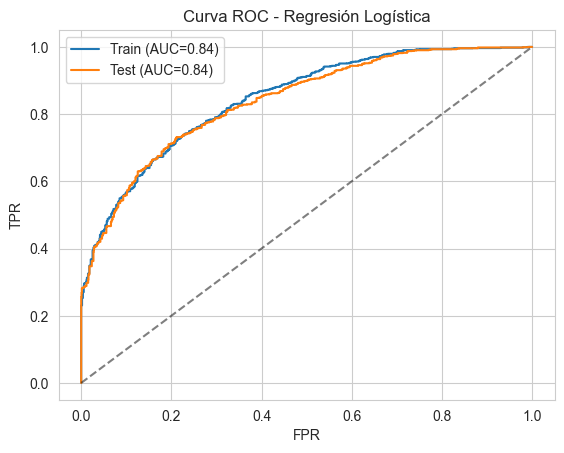


📋 Métricas resumidas:
  Muestra       AUC        KS  Threshold  Accuracy  Precision    Recall  \
0   Train  0.844959  0.512097   0.512614  0.773500   0.797563  0.860639   
1    Test  0.838897  0.519930   0.566578  0.761802   0.811514  0.811860   

         F1  
0  0.827901  
1  0.811687  


In [40]:
from sklearn.metrics import (
    roc_curve, roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score, confusion_matrix
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 📦 Función para evaluar modelo
def evaluar_logit(modelo, X, y, muestra):
    df = X.copy()
    df['Default'] = y
    pred = modelo.predict(df)

    # ROC y KS
    fpr, tpr, thresholds = roc_curve(y, pred)
    auc = roc_auc_score(y, pred)
    ks = max(tpr - fpr)

    # Umbral óptimo por máxima accuracy
    acc_list = [accuracy_score(y, (pred >= thr).astype(int)) for thr in thresholds]
    idx_max = np.argmax(acc_list)
    threshold_optimo = thresholds[idx_max]

    # Predicción binaria
    pred_class = (pred >= threshold_optimo).astype(int)

    # Métricas
    acc = accuracy_score(y, pred_class)
    prec = precision_score(y, pred_class)
    rec = recall_score(y, pred_class)
    f1 = f1_score(y, pred_class)
    cm = confusion_matrix(y, pred_class)

    print(f"\n📊 Resultados - {muestra.upper()}")
    print(f"AUC: {auc:.4f} | KS: {ks:.4f} | Threshold óptimo: {threshold_optimo:.4f}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Matriz de Confusión:")
    print(cm)

    # Curva ROC
    plt.plot(fpr, tpr, label=f'{muestra} (AUC={auc:.2f})')
    return {
        'Muestra': muestra,
        'AUC': auc,
        'KS': ks,
        'Threshold': threshold_optimo,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    }

# 🧪 Evaluar train y test
metricas_train = evaluar_logit(modelo_inicial, X_train_encoded, y_train, 'Train')
metricas_test = evaluar_logit(modelo_inicial, X_test_encoded, y_test, 'Test')

# 📈 Mostrar curva ROC
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.grid(True)
plt.show()

# 📋 DataFrame de métricas
metricas_inicial = pd.DataFrame([metricas_train, metricas_test])
print("\n📋 Métricas resumidas:")
print(metricas_inicial)


##### <span style="color: violet;">b. Modelo árboles: </span>

In [41]:
# Optimizacipón del arbol de decisión

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Definir el árbol base
tree = DecisionTreeClassifier(random_state=21)

# Definir la grilla de hiperparámetros
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [10, 20, 30],
    'criterion': ['gini', 'entropy']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ejecutar búsqueda
grid_search.fit(X_train_encoded, y_train)

# Mejor modelo
best_tree = grid_search.best_estimator_
print("🔍 Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
🔍 Mejor combinación de hiperparámetros:
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}



🌳 Árbol de decisión - TRAIN:
AUC: 0.9001
KS: 0.6217
Threshold óptimo: 0.6471
Accuracy: 0.7932
Precisión: 0.9129
Sensibilidad (Recall): 0.7443
Puntaje F1: 0.8200
Matriz de Confusión:
[[2785  389]
 [1400 4075]]

🌳 Árbol de decisión - TEST:
AUC: 0.8869
KS: 0.5978
Threshold óptimo: 0.7179
Accuracy: 0.7791
Precisión: 0.9080
Sensibilidad (Recall): 0.7240
Puntaje F1: 0.8056
Matriz de Confusión:
[[1191  172]
 [ 647 1697]]

📋 Métricas resumidas:
  Muestra       AUC        KS  Threshold  Accuracy  Precision    Recall  \
0   Train  0.900140  0.621734   0.647059  0.793155   0.912858  0.744292   
1    Test  0.886892  0.597784   0.717949  0.779067   0.907972  0.723976   

         F1  
0  0.820002  
1  0.805602  


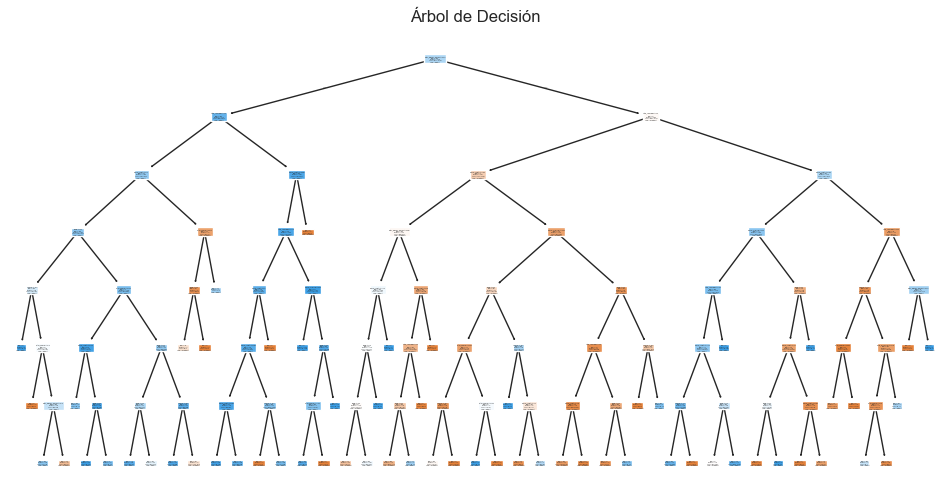


🔎 Importancia de variables:
Ratio_Ingresos_Deudas    0.281344
Deuda_Credito            0.245159
Años_Trabajando          0.176889
Edad                     0.119518
Deuda_Comercial          0.060707
Ingresos                 0.057798
Otras_Deudas             0.054330
Nivel_Educacional        0.004255
dtype: float64


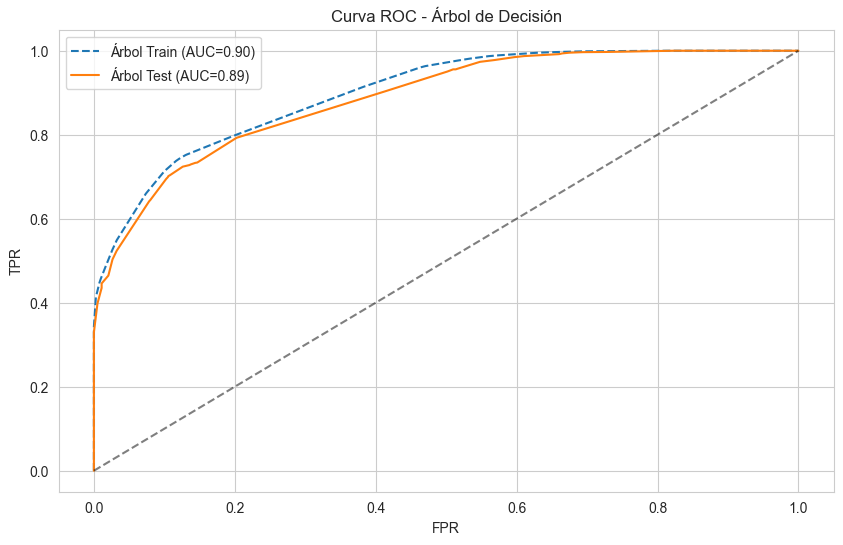

In [42]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    roc_curve, roc_auc_score, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Entrenar modelo
tree_model = DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=2, random_state=21)
tree_model.fit(X_train_encoded, y_train)

# Función para calcular métricas
def evaluar_modelo(modelo, X, y, muestra):
    probs = modelo.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, probs)
    auc = roc_auc_score(y, probs)
    ks = max(tpr - fpr)
    threshold_optimo = thresholds[np.argmax(tpr - fpr)]
    pred = (probs >= threshold_optimo).astype(int)

    acc = accuracy_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    f1 = f1_score(y, pred)
    cm = confusion_matrix(y, pred)

    print(f"\n🌳 Árbol de decisión - {muestra.upper()}:")
    print(f"AUC: {auc:.4f}")
    print(f"KS: {ks:.4f}")
    print(f"Threshold óptimo: {threshold_optimo:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precisión: {prec:.4f}")
    print(f"Sensibilidad (Recall): {rec:.4f}")
    print(f"Puntaje F1: {f1:.4f}")
    print("Matriz de Confusión:")
    print(cm)

    return {
        'Muestra': muestra,
        'AUC': auc,
        'KS': ks,
        'Threshold': threshold_optimo,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    }, fpr, tpr

# Evaluar train y test
metricas_train, fpr_train, tpr_train = evaluar_modelo(tree_model, X_train_encoded, y_train, 'Train')
metricas_test, fpr_test, tpr_test = evaluar_modelo(tree_model, X_test_encoded, y_test, 'Test')

# 📊 DataFrame de métricas
metricas_arbol = pd.DataFrame([metricas_train, metricas_test])
print("\n📋 Métricas resumidas:")
print(metricas_arbol)

# 🌲 Visualización del árbol
plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=X_train_encoded.columns, class_names=['No Default', 'Default'], filled=True)
plt.title("Árbol de Decisión")
plt.show()

# 🔍 Importancia de variables
importancias = pd.Series(tree_model.feature_importances_, index=X_train_encoded.columns)
importancias = importancias.sort_values(ascending=False)
print("\n🔎 Importancia de variables:")
print(importancias)

# 📈 Curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Árbol Train (AUC={metricas_train["AUC"]:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Árbol Test (AUC={metricas_test["AUC"]:.2f})', linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend()
plt.grid(True)
plt.show()


Optimization terminated successfully.
         Current function value: 0.457398
         Iterations 8

📊 LOGIT - TRAIN
AUC: 0.8450 | KS: 0.5121 | Threshold óptimo (F1): 0.3789
Accuracy: 0.7653 | Precision: 0.7509 | Recall: 0.9416 | F1: 0.8355
Matriz de Confusión:
[[1464 1710]
 [ 320 5155]]

📊 LOGIT - TEST
AUC: 0.8389 | KS: 0.5199 | Threshold óptimo (F1): 0.3533
Accuracy: 0.7453 | Precision: 0.7315 | Recall: 0.9437 | F1: 0.8241
Matriz de Confusión:
[[ 551  812]
 [ 132 2212]]

📊 TREE - TRAIN
AUC: 0.8173 | KS: 0.4890 | Threshold óptimo (F1): 0.4146
Accuracy: 0.7544 | Precision: 0.7424 | Recall: 0.9374 | F1: 0.8285
Matriz de Confusión:
[[1393 1781]
 [ 343 5132]]

📊 TREE - TEST
AUC: 0.8103 | KS: 0.4790 | Threshold óptimo (F1): 0.4038
Accuracy: 0.7337 | Precision: 0.7178 | Recall: 0.9539 | F1: 0.8192
Matriz de Confusión:
[[ 484  879]
 [ 108 2236]]


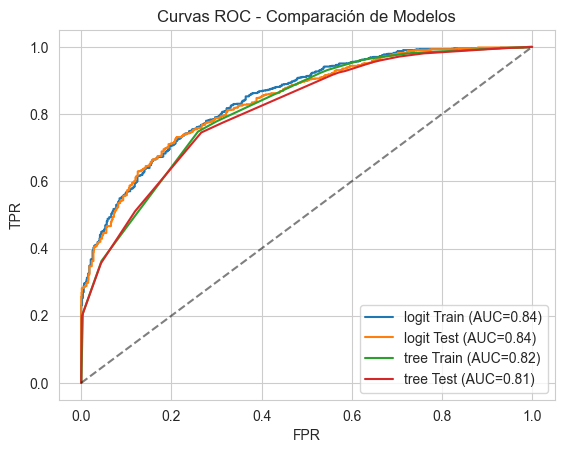


📋 Comparación de modelos:
  Modelo Muestra       AUC        KS  Threshold  Accuracy  Precision  \
0  logit   Train  0.844959  0.512097   0.378949  0.765291   0.750910   
1  logit    Test  0.838897  0.519930   0.353258  0.745347   0.731481   
2   tree   Train  0.817260  0.488966   0.414634  0.754422   0.742369   
3   tree    Test  0.810299  0.478983   0.403785  0.733747   0.717817   

     Recall        F1  
0  0.941553  0.835494  
1  0.943686  0.824143  
2  0.937352  0.828544  
3  0.953925  0.819198  


In [43]:
# 1. Entrenamiento de modelos
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm

# Árbol
tree_model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=75, random_state=21)
tree_model.fit(X_train_encoded, y_train)

# Regresión logística
df_train_encoded = X_train_encoded.copy()
df_train_encoded['Default'] = y_train
formula = 'Default ~ Edad + Nivel_Educacional + Años_Trabajando + Ingresos + Deuda_Comercial + Deuda_Credito + Otras_Deudas + Ratio_Ingresos_Deudas'
modelo_inicial = sm.Logit.from_formula(formula, data=df_train_encoded).fit()

# 2. Función de evaluación por F1
def evaluar_modelo_por_f1(modelo, X, y, muestra, tipo='logit'):
    from sklearn.metrics import (
        roc_curve, roc_auc_score, accuracy_score,
        precision_score, recall_score, f1_score, confusion_matrix
    )
    import numpy as np

    if tipo == 'logit':
        df = X.copy()
        df['Default'] = y
        probs = modelo.predict(df)
    else:
        probs = modelo.predict_proba(X)[:, 1]

    fpr, tpr, thresholds = roc_curve(y, probs)
    auc = roc_auc_score(y, probs)
    ks = max(tpr - fpr)
    f1_scores = [f1_score(y, (probs >= thr).astype(int)) for thr in thresholds]
    idx_max = np.argmax(f1_scores)
    threshold_optimo = thresholds[idx_max]
    pred_class = (probs >= threshold_optimo).astype(int)

    acc = accuracy_score(y, pred_class)
    prec = precision_score(y, pred_class)
    rec = recall_score(y, pred_class)
    f1 = f1_score(y, pred_class)
    cm = confusion_matrix(y, pred_class)

    print(f"\n📊 {tipo.upper()} - {muestra.upper()}")
    print(f"AUC: {auc:.4f} | KS: {ks:.4f} | Threshold óptimo (F1): {threshold_optimo:.4f}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Matriz de Confusión:")
    print(cm)

    return {
        'Modelo': tipo,
        'Muestra': muestra,
        'AUC': auc,
        'KS': ks,
        'Threshold': threshold_optimo,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    }

# 3. Evaluación
metricas = []
for modelo, tipo in [(modelo_inicial, 'logit'), (tree_model, 'tree')]:
    for X, y, muestra in [(X_train_encoded, y_train, 'Train'), (X_test_encoded, y_test, 'Test')]:
        resultado = evaluar_modelo_por_f1(modelo, X, y, muestra, tipo)
        metricas.append(resultado)

# 4. Visualización ROC
import matplotlib.pyplot as plt
for resultado in metricas:
    modelo = resultado['Modelo']
    muestra = resultado['Muestra']
    # Recalcular fpr/tpr para graficar
    if modelo == 'logit':
        df = X_train_encoded.copy() if muestra == 'Train' else X_test_encoded.copy()
        df['Default'] = y_train if muestra == 'Train' else y_test
        probs = modelo_inicial.predict(df)
    else:
        probs = tree_model.predict_proba(X_train_encoded if muestra == 'Train' else X_test_encoded)[:, 1]
    fpr, tpr, _ = roc_curve(y_train if muestra == 'Train' else y_test, probs)
    plt.plot(fpr, tpr, label=f'{modelo} {muestra} (AUC={resultado["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC - Comparación de Modelos')
plt.legend()
plt.grid(True)
plt.show()

# 5. DataFrame final
metricas_df = pd.DataFrame(metricas)
print("\n📋 Comparación de modelos:")
print(metricas_df)
